# Морфологічний аналіз - ризики

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
# Jupyter rendering stuff
from IPython.display import display, Math, Latex, HTML, clear_output
import itertools
from pylab import *

## Data generation

In [2]:
def generate_probabilities(*sizes):
    result = [np.random.random(size) for size in sizes]
    for vec in result:
        vec /= np.sum(vec)
    return result

In [12]:
factor_s = (2,3,4)
factor_p = generate_probabilities(*factor_s)
risks_no = 2
factor_eta = [generate_probabilities(*factor_s) for r in range(risks_no)]
factor_W =   [generate_probabilities(*factor_s) for r in range(risks_no)]

## Setting constants

In [4]:
eta_ranges_c = W_ranges_c = np.arange(0, 1.2, 0.2)
eta_ranges_b = W_ranges_b = 0.2
# to review

## Calculating risks

In [5]:
def reside_function(x, b, c):
    def s(x, a, b, c):
        result = np.zeros_like(x)
        mask1 = (x > a) * (x <= b)
        mask2 = (x > b) * (x <= c)
        result[mask1] = 2 * ((x[mask1] - a) / (c - a))**2
        result[mask2] = 1 - 2 * ((x[mask2] - c) / (c - a))**2
        result[x > c] = 1
        return result
    return s(x, c - b, c - b / 2, c) * (x <= c) + (1 - s(x, c, c + b / 2, c + b)) * (x > c)

In [6]:
def aggregate_risk_values(splitted_values):
    result = []
    for tup in zip(*splitted_values):
        result.append(1 - np.prod(1 - np.vstack(tup), axis=0))
    return result

In [13]:
eta = aggregate_risk_values(factor_eta)
W =   aggregate_risk_values(factor_W)

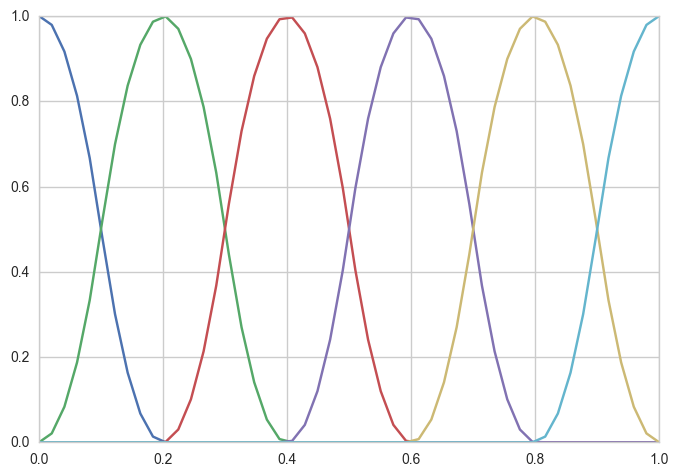

In [8]:
for c in eta_ranges_c:
    plot(np.linspace(0,1), reside_function(np.linspace(0, 1), eta_ranges_b, c))

In [9]:
def calculate_eta_W_resid_vectors(eta, W):
    global eta_ranges_c, eta_ranges_b
    global W_ranges_c, W_ranges_b
    eta_vec = np.array([reside_function(eta, eta_ranges_b, c) for c in eta_ranges_c])
    W_vec = np.array([reside_function(W, W_ranges_b, c) for c in W_ranges_c])
    return eta_vec, W_vec

In [10]:
def build_resid_table(configuration):
    global eta_ranges_c, W_ranges_c
    global eta, W
    res_eta = 1
    res_W = 1
    for i, f_eta, f_W in zip(configuration, eta, W):
        eta_vec, W_vec = calculate_eta_W_resid_vectors(f_eta[i], f_W[i])
        res_eta *= 1 - eta_vec
        res_W *= 1 - W_vec
    res_eta = 1 - res_eta
    res_W = 1 - res_W
    return np.sqrt(res_eta[:, None] @ res_W[None, :])

In [11]:
pd.DataFrame(build_resid_table((1,1,1)), columns=['$I_W^%d$' % (i + 1) for i in range(len(W_ranges_c))],
             index=['$I_\eta^%d$' % (i + 1) for i in range(len(eta_ranges_c))])

,$I_W^1$,$I_W^2$,$I_W^3$,$I_W^4$,$I_W^5$,$I_W^6$
$I_\eta^1$,0.0,0.0,0.000000,0.000000,0.000000,0.0
$I_\eta^2$,0.0,0.0,0.000000,0.000000,0.000000,0.0
$I_\eta^3$,0.0,0.0,0.683832,0.928732,0.908794,0.0
$I_\eta^4$,0.0,0.0,0.728266,0.989078,0.967845,0.0
$I_\eta^5$,0.0,0.0,0.479468,0.651179,0.637200,0.0
$I_\eta^6$,0.0,0.0,0.000000,0.000000,0.000000,0.0


## Calculating risks in general

In [17]:
def build_resid_table_general(eta_gen, W_gen):
    res_eta = 1
    res_W = 1
    for f_eta, f_W in zip(eta_gen, W_gen):
        eta_vec, W_vec = calculate_eta_W_resid_vectors(f_eta, f_W)
        res_eta *= 1 - eta_vec
        res_W *= 1 - W_vec
    res_eta = 1 - res_eta
    res_W = 1 - res_W
    return np.sqrt(res_eta[:, None] @ res_W[None, :])

In [15]:
eta_general = [np.dot(e, p) for e, p in zip(eta, factor_p)]
W_general = [np.dot(w, p) for w, p in zip(W, factor_p)]

In [20]:
print(eta_general)
print(W_general)

[0.90716817043678699, 0.54098088629783203, 0.45696217197999067]
[0.8831060456942823, 0.57940707887435539, 0.4575561868701451]


In [19]:
pd.DataFrame(build_resid_table_general(eta_general, W_general), columns=['$I_W^%d$' % (i + 1) for i in range(len(W_ranges_c))],
             index=['$I_\eta^%d$' % (i + 1) for i in range(len(eta_ranges_c))])

,$I_W^1$,$I_W^2$,$I_W^3$,$I_W^4$,$I_W^5$,$I_W^6$
$I_\eta^1$,0.0,0.0,0.000000,0.000000,0.000000,0.000000
$I_\eta^2$,0.0,0.0,0.000000,0.000000,0.000000,0.000000
$I_\eta^3$,0.0,0.0,0.851832,0.922334,0.752966,0.546867
$I_\eta^4$,0.0,0.0,0.845946,0.915960,0.747762,0.543088
$I_\eta^5$,0.0,0.0,0.600858,0.650588,0.531120,0.385744
$I_\eta^6$,0.0,0.0,0.690540,0.747693,0.610394,0.443319
